In [92]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,TensorDataset
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import copy


## Load dataset

In [93]:

def load_cmapss(file_name):
    df = pd.read_csv(file_name,sep='\s+',header=None)
    df.dropna(axis=1, inplace=True)  # Remove empty columns
    df.columns = ['unit', 'time','setting_1', 'setting_2', 'setting_3'] + [f's{i}' for i in range(1, 22)]
    df.drop(['setting_1','setting_2','setting_3','s1','s5','s6','s10','s16','s18','s19'],axis=1,inplace=True) # dropping sensors that have low corr with RUL
    return df

data = load_cmapss('train_FD001.txt')
data.head()

,unit,time,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


In [94]:
'''# Normalize each unit
def normalize_per_engine(df):
    df_norm = df.copy()
    for engine_id in df['unit'].unique():
        engine_data = df[df['unit'] == engine_id]
        scaler = MinMaxScaler()
        df_norm.loc[df['unit'] == engine_id, df.columns[2:]] = scaler.fit_transform(engine_data.iloc[:, 2:])
    return df_norm

data=normalize_per_engine(data)'''

"# Normalize each unit\ndef normalize_per_engine(df):\n    df_norm = df.copy()\n    for engine_id in df['unit'].unique():\n        engine_data = df[df['unit'] == engine_id]\n        scaler = MinMaxScaler()\n        df_norm.loc[df['unit'] == engine_id, df.columns[2:]] = scaler.fit_transform(engine_data.iloc[:, 2:])\n    return df_norm\n\ndata=normalize_per_engine(data)"

## Smooth data - Moving average

In [95]:
data_to_smooth = data.drop('time', axis=1)
data_to_smooth.head()
smoothed_df = data_to_smooth.groupby('unit').apply(lambda group: group.rolling(window=30, min_periods=1).mean()).reset_index(drop=True)
smoothed_df.insert(1, 'time', data['time'])

C:\Users\deeks\AppData\Local\Temp\ipykernel_16428\2274170396.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  smoothed_df = data_to_smooth.groupby('unit').apply(lambda group: group.rolling(window=30, min_periods=1).mean()).reset_index(drop=True)


## Normalize data 

In [96]:
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(smoothed_df.iloc[:, 2:])
data.iloc[:, 2:] = pd.DataFrame(df_normalized)
data.head()

,unit,time,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,1,0.170063,0.562519,0.335837,0.741048,0.387812,0.094341,0.464849,0.597227,0.256898,0.218018,0.488517,0.329670,0.737937,0.740470
1,1,2,0.245902,0.598267,0.368100,0.662849,0.360111,0.087167,0.473458,0.699571,0.328259,0.191440,0.522199,0.329670,0.700499,0.745620
2,1,3,0.301823,0.567128,0.387830,0.680369,0.387812,0.104788,0.413199,0.749092,0.313987,0.186905,0.507868,0.219780,0.667221,0.688071
3,1,4,0.329784,0.507717,0.382897,0.701308,0.422438,0.107743,0.352941,0.810168,0.342531,0.185755,0.432792,0.247253,0.628744,0.675924
4,1,5,0.348399,0.472475,0.402039,0.690796,0.415512,0.117192,0.342611,0.802575,0.336822,0.185021,0.454781,0.296703,0.610649,0.682294


## Train test split

In [97]:
# Split data into healthy (first 70 samples per unit) and anomaly (time > 130)
healthy_data = data.groupby('unit').head(70)
anomaly_df = data[data['time'] > 130]

# Define validation units (randomly selected)
validation_units = [3, 13, 23, 33, 43, 53, 63, 73, 83, 93, 10, 75, 68, 88, 42, 39, 9, 19, 2]

# Split healthy data into validation and training sets
val_df = healthy_data[healthy_data['unit'].isin(validation_units)]
train_df = healthy_data[~healthy_data['unit'].isin(validation_units)]

## Generate seqeunces from train, test and val dataset into sequences

In [98]:

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set sequence length
seq_length=50

# Create sequences
def create_sequences(df, seq_length):
    sequences = []
    for engine_id in df["unit"].unique():
        engine_data = df[df["unit"] == engine_id].iloc[:, 2:].values  # Exclude unit & cycle columns
        for i in range(len(engine_data) - seq_length):
            sequences.append(engine_data[i : i + seq_length])
    
    return torch.tensor(sequences, dtype=torch.float32, device=device)  # Move data to GPU

# Create datasets
train_data = create_sequences(train_df,seq_length)
val_data = create_sequences(val_df,seq_length)
test_anomaly_data = create_sequences(anomaly_df,seq_length)


## Transformer model

In [99]:



class TransformerAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, d_model=128, nhead=8, num_encoder_layers=2, dim_feedforward=512, dropout=0.2):
        super(TransformerAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.d_model = d_model

        # Embedding layer to project input features to d_model dimensions
        self.embedding = nn.Linear(n_features, d_model)

        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_len, d_model))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="gelu",  # Use GELU activation for better performance
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Replace Transformer Decoder with Dense Layers
        self.decoder = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),  # First dense layer
            nn.ReLU(),  # Activation function
            nn.Linear(dim_feedforward, n_features),  # Final projection to original feature space
        )

        # Layer normalization for stability
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        # Embed input features
        x = self.embedding(x) + self.positional_encoding
        x = self.layer_norm(x)  # Apply layer normalization

        # Encoder
        memory = self.encoder(x)

        # Decoder (using dense layers)
        output = self.decoder(memory)  # Pass memory through dense layers

        return output, memory





In [100]:

n_features = 14 # No,. of input features
model = TransformerAutoencoder(seq_len=seq_length,n_features=n_features).to(device)
# Define batch size
BATCH_SIZE = 32

# DataLoader for mini-batching 
train_loader = DataLoader(TensorDataset(train_data), batch_size=BATCH_SIZE, shuffle=True,num_workers=4, pin_memory=True)
val_loader = DataLoader(TensorDataset(val_data), batch_size=BATCH_SIZE, shuffle=False,num_workers=4, pin_memory=True)
test_loader = DataLoader(TensorDataset(test_anomaly_data), batch_size=BATCH_SIZE, shuffle=False,num_workers=4, pin_memory=True)


C:\Users\deeks\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Training

Epoch 1: train loss 0.0154, val loss 0.0012
Epoch 2: train loss 0.0020, val loss 0.0010
Epoch 3: train loss 0.0014, val loss 0.0009
Epoch 4: train loss 0.0011, val loss 0.0007
Epoch 5: train loss 0.0009, val loss 0.0007
Epoch 6: train loss 0.0007, val loss 0.0005
Epoch 7: train loss 0.0006, val loss 0.0005
Epoch 8: train loss 0.0005, val loss 0.0004
Epoch 9: train loss 0.0005, val loss 0.0004
Epoch 10: train loss 0.0004, val loss 0.0004
Epoch 11: train loss 0.0004, val loss 0.0003
Epoch 12: train loss 0.0003, val loss 0.0002
Epoch 13: train loss 0.0003, val loss 0.0003
Epoch 14: train loss 0.0002, val loss 0.0003
Epoch 15: train loss 0.0002, val loss 0.0002
Epoch 16: train loss 0.0002, val loss 0.0003
Epoch 17: train loss 0.0002, val loss 0.0002
Epoch 18: train loss 0.0001, val loss 0.0002
Epoch 19: train loss 0.0001, val loss 0.0002
Epoch 20: train loss 0.0001, val loss 0.0002


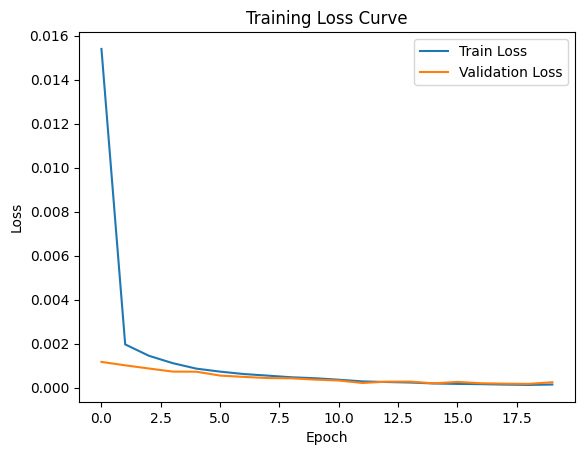

In [101]:
def train(model, train_loader, val_loader, epochs=15, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    history = {"train": [], "val": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_losses = []

        for batch in train_loader:
            seq_true = batch[0].to(device)  # Move to GPU/CPU
            optimizer.zero_grad()
            
            seq_pred,_ = model(seq_true)
            
            # Ensure output shape matches target
            if seq_pred.shape != seq_true.shape:
                seq_pred = seq_pred.view_as(seq_true)

            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                seq_true = batch[0].to(device)
                seq_pred,_ = model(seq_true)

                # Ensure output shape matches target
                if seq_pred.shape != seq_true.shape:
                    seq_pred = seq_pred.view_as(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss, val_loss = np.mean(train_losses), np.mean(val_losses)
        history["train"].append(train_loss)
        history["val"].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch+1}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history

# Train the model
model, history = train(model, train_loader, val_loader, epochs=20)

# Plot Loss Curve
plt.plot(history["train"], label="Train Loss")
plt.plot(history["val"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Curve")
plt.show()

## Prediction and reconstruction visualization

C:\Users\deeks\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([50, 14])) that is different to the input size (torch.Size([1, 50, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


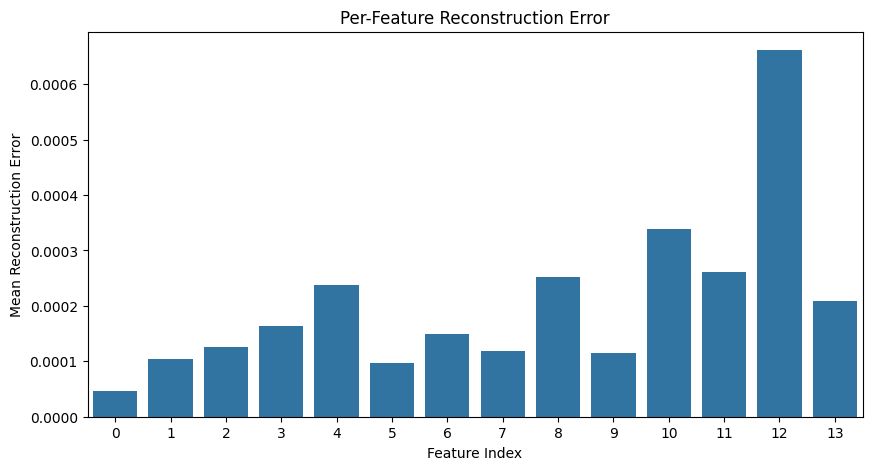

In [102]:
def predict_per_feature(model, dataset):
    model.eval()
    criterion = nn.MSELoss(reduction="none")  # No reduction to get per-feature loss
    feature_losses = []
    
    with torch.no_grad():
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred,_ = model(seq_true)
            
            # Compute per-feature error (MSE over time, mean over sequence length)
            loss = criterion(seq_pred, seq_true).mean(dim=(0, 1))  # Mean over time and batch
            feature_losses.append(loss.cpu().numpy())

    feature_losses = np.array(feature_losses)
    mean_feature_loss = np.mean(feature_losses, axis=0)  # Mean over all samples

    return mean_feature_loss

# Get per-feature reconstruction error
per_feature_loss = predict_per_feature(model, train_data)

# Plot per-feature loss
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(per_feature_loss)), y=per_feature_loss)
plt.xlabel("Feature Index")
plt.ylabel("Mean Reconstruction Error")
plt.title("Per-Feature Reconstruction Error")
plt.show()

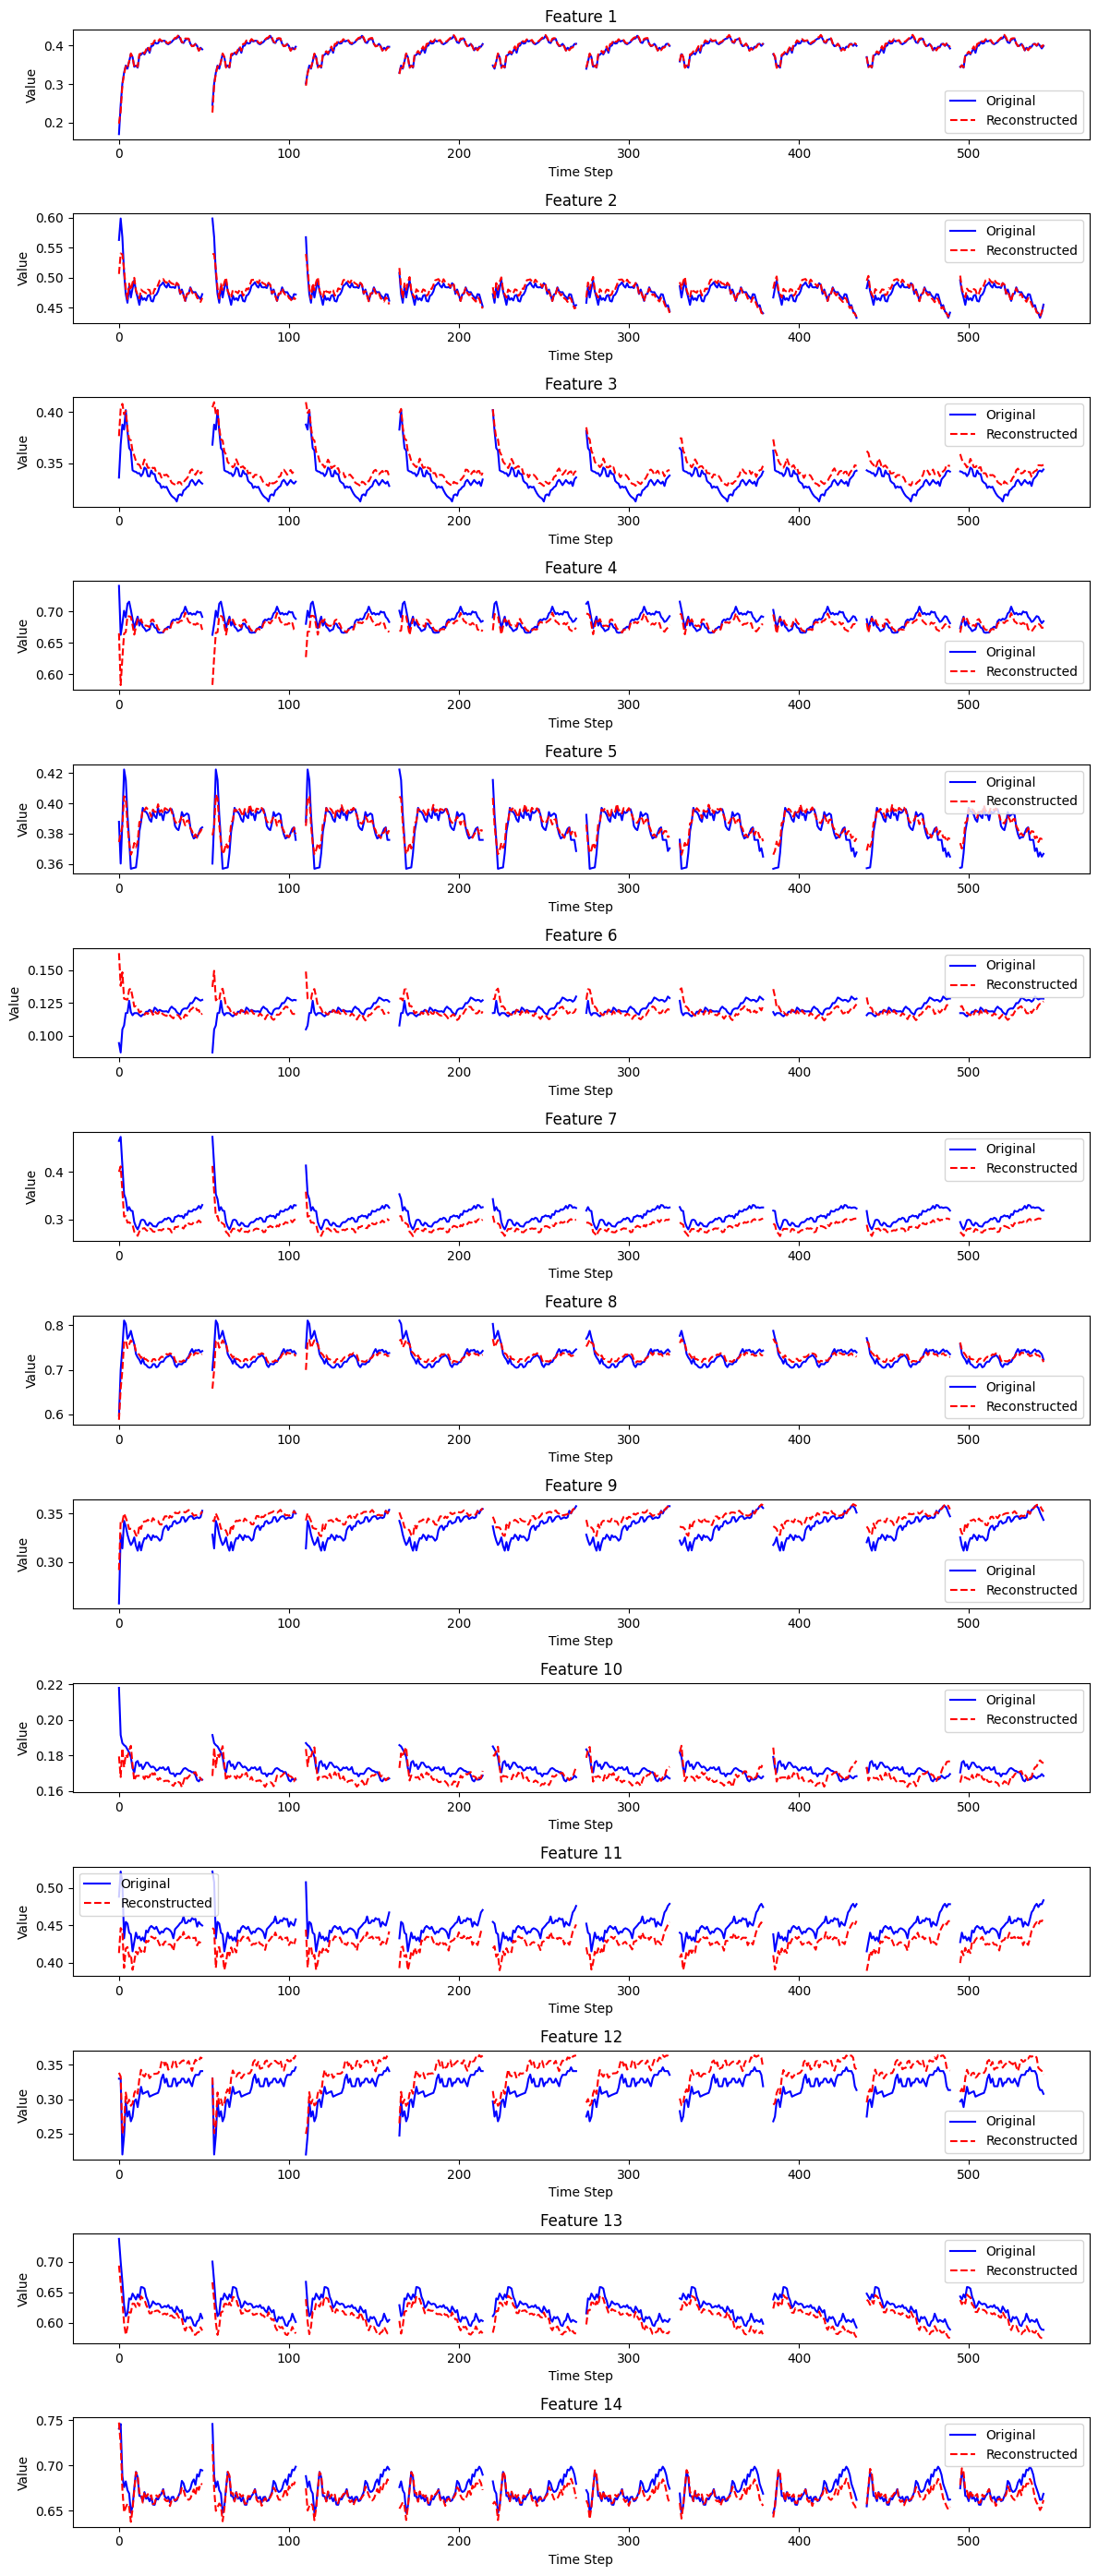

In [103]:
def visualize_reconstructions_sequentially(model, dataset, sample_indices=[0, 1, 2]):
    model.eval()
    
    num_features = dataset[0].shape[1]  # Number of features
    total_seq_length = sum(dataset[idx].shape[0] for idx in sample_indices)  # Total sequence length
    
    # Prepare concatenated arrays for original and reconstructed sequences
    concatenated_original = []
    concatenated_reconstructed = []
    separator = None  # For adding a gap between sequences

    for idx in sample_indices:
        sample_seq = dataset[idx].unsqueeze(0).to(device)  # Add batch dimension
        
        with torch.no_grad():
            reconstructed_seq, _ = model(sample_seq)  # Extract output from the tuple
            reconstructed_seq = reconstructed_seq.cpu().numpy().squeeze()
        
        original_seq = sample_seq.cpu().numpy().squeeze()

        if separator is None:
            separator = np.full((5, num_features), np.nan)  # Create NaN separator for gaps
        
        # Append sequence data and separator
        concatenated_original.append(original_seq)
        concatenated_original.append(separator)
        concatenated_reconstructed.append(reconstructed_seq)
        concatenated_reconstructed.append(separator)

    # Convert list to array
    original_seq = np.vstack(concatenated_original)
    reconstructed_seq = np.vstack(concatenated_reconstructed)
    
    # Plot the sequences sequentially
    plt.figure(figsize=(12, num_features * 2))
    
    for i in range(num_features):
        plt.subplot(num_features, 1, i + 1)
        plt.plot(original_seq[:, i], label="Original", color="blue")
        plt.plot(reconstructed_seq[:, i], label="Reconstructed", color="red", linestyle="dashed")
        plt.title(f"Feature {i+1}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Visualize multiple sequences sequentially
visualize_reconstructions_sequentially(model, train_data, sample_indices=list(range(10)))

## Degradation onset detection

In [104]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.MSELoss() #reduction='sum'
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      
      seq_pred,_ = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
        
  return predictions, losses

# Get per-feature reconstruction error
_, losses = predict(model, train_data)

C:\Users\deeks\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([50, 14])) that is different to the input size (torch.Size([1, 50, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


C:\Users\deeks\AppData\Local\Temp\ipykernel_16428\2307412100.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses_train, bins=20, kde=True)


Text(0.5, 1.0, 'Reconstruction Error Distribution of initial timesteps')

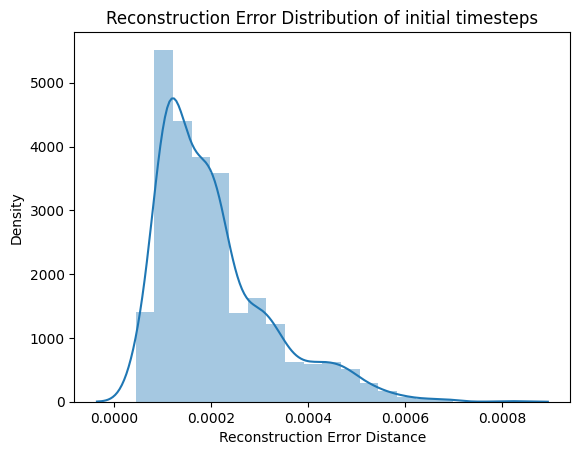

In [105]:
_, losses_train = predict(model, train_data)
sns.distplot(losses_train, bins=20, kde=True)
plt.xlabel("Reconstruction Error Distance")
plt.ylabel("Density")
plt.title("Reconstruction Error Distribution of initial timesteps")

In [106]:
# Set threshold
threshold = np.percentile(losses_train,95)
print("Threshold: ", threshold)

Threshold:  0.0004569120777887292


C:\Users\deeks\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([50, 14])) that is different to the input size (torch.Size([1, 50, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\deeks\AppData\Local\Temp\ipykernel_16428\2487374619.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses_test, bins=20, kde=True)


Text(0.5, 1.0, 'Reconstruction Error Distribution of final timesteps')

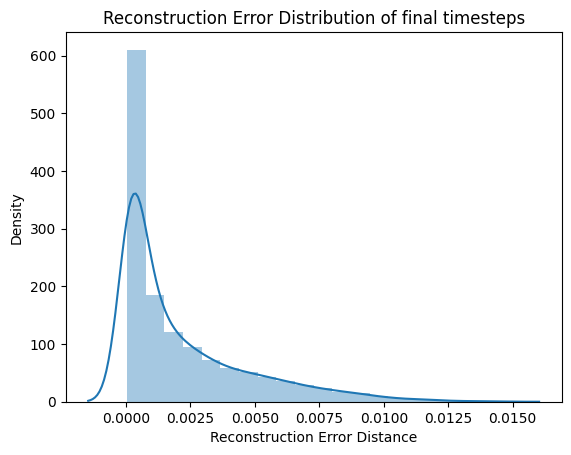

In [107]:
_, losses_test = predict(model, test_anomaly_data)

sns.distplot(losses_test, bins=20, kde=True)
plt.xlabel("Reconstruction Error Distance")
plt.ylabel("Density")
plt.title("Reconstruction Error Distribution of final timesteps")

In [108]:
temp_data=create_sequences(data[data.unit==1],seq_length)
predictions, pred_losses = predict(model, temp_data)

C:\Users\deeks\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([50, 14])) that is different to the input size (torch.Size([1, 50, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Text(0.5, 1.0, 'Reconstruction Error Distribution of final timesteps')

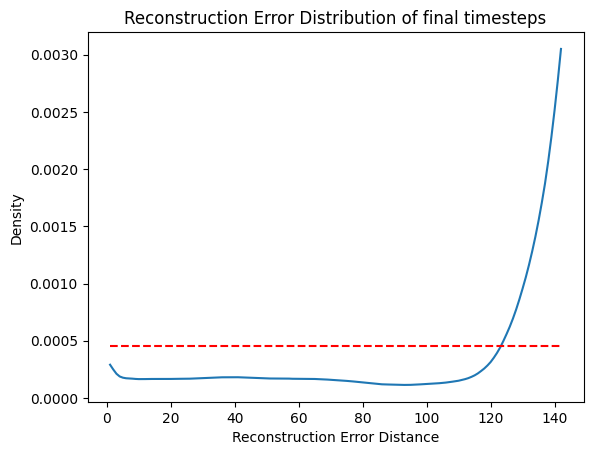

In [109]:

plt.plot(range(1,temp_data.shape[0] + 1),pred_losses)
plt.plot(range(1,temp_data.shape[0] + 1),[threshold]*(temp_data.shape[0]),color='r', linestyle='--', label=f'Threshold ({threshold})')

plt.xlabel("Reconstruction Error Distance")
plt.ylabel("Density")
plt.title("Reconstruction Error Distribution of final timesteps")

In [110]:
for u in data.unit.unique():
    temp_data=create_sequences(data[data.unit==u],seq_length)
    predictions, pred_losses = predict(model, temp_data)
    print('Degrdation for engine ' ,u, 'onsets at time ',np.where(pred_losses>threshold)[0][5])

Degrdation for engine  1 onsets at time  128
Degrdation for engine  2 onsets at time  215
Degrdation for engine  3 onsets at time  107
Degrdation for engine  4 onsets at time  118
Degrdation for engine  5 onsets at time  5
Degrdation for engine  6 onsets at time  69
Degrdation for engine  7 onsets at time  176
Degrdation for engine  8 onsets at time  48
Degrdation for engine  9 onsets at time  98
Degrdation for engine  10 onsets at time  156
Degrdation for engine  11 onsets at time  164
Degrdation for engine  12 onsets at time  76
Degrdation for engine  13 onsets at time  85
Degrdation for engine  14 onsets at time  92
Degrdation for engine  15 onsets at time  146
Degrdation for engine  16 onsets at time  60
Degrdation for engine  17 onsets at time  168
Degrdation for engine  18 onsets at time  113
Degrdation for engine  19 onsets at time  54
Degrdation for engine  20 onsets at time  123
Degrdation for engine  21 onsets at time  125
Degrdation for engine  22 onsets at time  36
Degrdati